In [2]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

from utils import train_test_split2, generate_portfolio_inputs
from network import MLP, PortfolioLayer
from config import DATA_PATH, PARA_PATH, PRICE_PATH
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna import trial

# Data Preprocessing

In [30]:
# import data and trained network parameters
features = pd.read_csv(DATA_PATH , index_col='Date')
prices   = pd.read_csv(PRICE_PATH, index_col='Date')
prices.index = pd.to_datetime(prices.index)

In [184]:
from abc import ABCMeta, abstractmethod
from scipy.optimize import minimize, Bounds, LinearConstraint, root


class RiskParity:
    def __init__(self, data:pd.DataFrame, bound:list = [0, 1]):
        self.data = {}
        self.data["price"] = data
        self.data["lret"]  = np.log(data/data.shift(1)).fillna(0)
        self.data["rv"]    = self.data["lret"].add(1)
        self.num_assets = self.data["price"].shape[1]

        # portoflio weight and performance dataframes which are to be filled.
        self.allocation   = pd.DataFrame(index=self.data["price"].index, columns=self.data["price"].columns)
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['cumulative_return']) # cumulative return
        
        # Optimization constraints
        self.bounds = Bounds([bound[0]]*self.num_assets, [bound[1]]*self.num_assets)  # 모든 weight 의 lower limit 부여. Default: 0 <= x
        self.constraint = LinearConstraint([[1]*self.num_assets], [1], [1])  # 모든 weight 의 합은 1 이라는 조건 부여
        self.b = np.array([1/self.num_assets] * self.num_assets)
  
    def obj_func(self, w: np.ndarray, cov: np.ndarray):
        var = w.T @ cov @ w
        diff = (cov @ w)/var * w - self.b
        return np.sum(abs(diff)) # relative risk contribution is equal to 1/N
        
    def calc_weight(self, cov: np.ndarray) -> np.array:
        # define initial weight to optimize
        init_w = self.b.copy()
        result = minimize(fun=self.obj_func, x0=init_w, args=(cov), bounds=self.bounds, constraints=self.constraint) # minimize port. variance
        return result['x'] #normalize the weight

    def run(self):
        # calculate portfolio weight first.
        lret = self.data['lret']
        rv   = self.data['rv'] 
        months = pd.unique(lret.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'
        
        aum = 1 # for each month, we calculate the weight
        for idx in range(1,len(months)):
            last_month = months[idx-1] 
            this_month = months[idx]

            # using the daily return data of the last month, update weight this month
            cov = lret.loc[last_month,:].cov().values
            weight = self.calc_weight(cov)
            self.allocation.loc[this_month,:] = weight.T
            self.equity_curve.loc[this_month,:] = (rv.loc[this_month,:].cumprod(axis = 0) @ self.allocation.loc[this_month,:].iloc[-1:].T).values * aum
            aum = self.equity_curve.loc[this_month,:].iloc[-1].values # update aum as the latest value of this month.

    def performance(self):
        df_profit_history = self.equity_curve
        df_profit_history = (df_profit_history / (df_profit_history.shift().fillna(1)))-1
        df_mean = df_profit_history.rolling(252).mean() * 252
        df_std = df_profit_history.rolling(252).std() * np.sqrt(252)
        self.annual_sharpe = (df_mean)/(df_std)

In [185]:
rp = RiskParity(prices.iloc[1:])

In [186]:
rp.run()


In [187]:
lret = np.log(prices/prices.shift(1)).fillna(0)

In [191]:
covv = lret.loc['2006-02'].cov().values * 252
w = rp.allocation.loc['2016-03'].iloc[0].values

<AxesSubplot:xlabel='Date'>

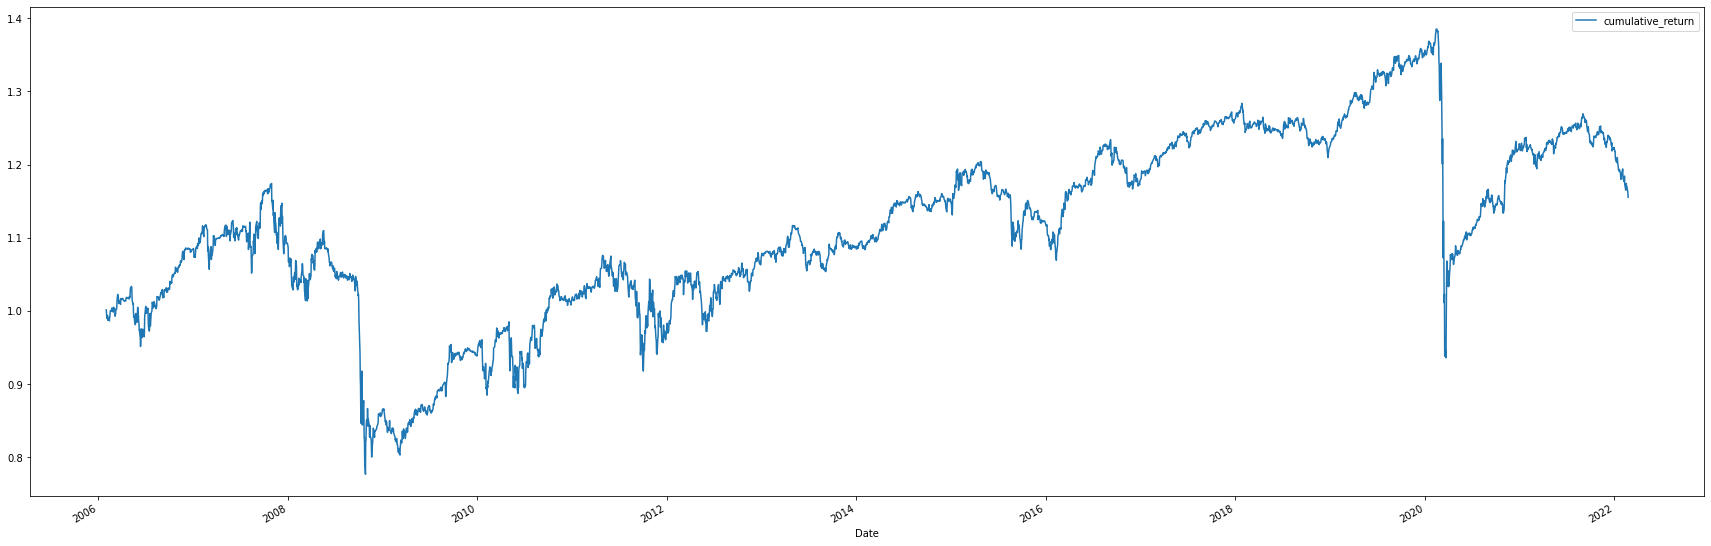

In [196]:
rp.equity_curve.plot(figsize=(30,10))

In [179]:
covv

array([[ 9.81656764e-03,  4.85576168e-05,  7.09532624e-03,
         2.56437914e-03,  6.45584976e-03,  1.72839606e-02,
        -1.81907744e-04,  7.89451380e-03],
       [ 4.85576168e-05,  1.41707381e-05,  2.81794898e-04,
         2.51488382e-05, -1.92964485e-04,  2.32338518e-04,
        -1.05489790e-06,  6.84399994e-05],
       [ 7.09532624e-03,  2.81794898e-04,  1.09122688e-02,
         2.39185839e-03,  2.98436060e-03,  1.62099223e-02,
        -1.24211311e-04,  7.35977411e-03],
       [ 2.56437914e-03,  2.51488382e-05,  2.39185839e-03,
         1.06535010e-03,  2.72090913e-03,  6.50192590e-03,
        -4.62352186e-05,  3.43349621e-03],
       [ 6.45584976e-03, -1.92964485e-04,  2.98436060e-03,
         2.72090913e-03,  1.35996591e-02,  1.54091954e-02,
        -9.62564986e-05,  9.10818479e-03],
       [ 1.72839606e-02,  2.32338518e-04,  1.62099223e-02,
         6.50192590e-03,  1.54091954e-02,  4.40147754e-02,
        -3.00578447e-04,  2.08137008e-02],
       [-1.81907744e-04, -1.054897

In [180]:
w_test

array([0.11804681899741022, 0.0, 0.11032527632867427, 0.5061758431300851,
       0.11015615656517719, 0.08098858769026758, 1.734723475976807e-17,
       0.07430731728838559], dtype=object)